In [6]:
from transformers import Sam3Processor, Sam3Model
import torch
from PIL import Image
import requests

device = "mps" if torch.cuda.is_available() else "cpu"
print(device)
model = Sam3Model.from_pretrained("facebook/sam3").to(device)
processor = Sam3Processor.from_pretrained("facebook/sam3")

# Load image
image_path = "./20240425_112716_nist-sand-30-100_27keV_z8mm_n2625_00000.png"
image = Image.open(image_path).convert("RGB")

# Segment using text prompt
inputs = processor(images=image, text="sand", return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

# Post-process results
results = processor.post_process_instance_segmentation(
    outputs,
    threshold=0.5,
    mask_threshold=0.5,
    target_sizes=inputs.get("original_sizes").tolist()
)[0]

print(f"Found {len(results['masks'])} objects")
# Results contain:
# - masks: Binary masks resized to original image size
# - boxes: Bounding boxes in absolute pixel coordinates (xyxy format)
# - scores: Confidence scores


cpu


Loading weights: 100%|██████████| 1468/1468 [00:01<00:00, 1331.44it/s, Materializing param=vision_encoder.neck.fpn_layers.3.proj2.weight]                       


The OrderedVocab you are attempting to save contains holes for indices [1], your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains holes for indices [1], your vocabulary could be corrupted !
Found 0 objects


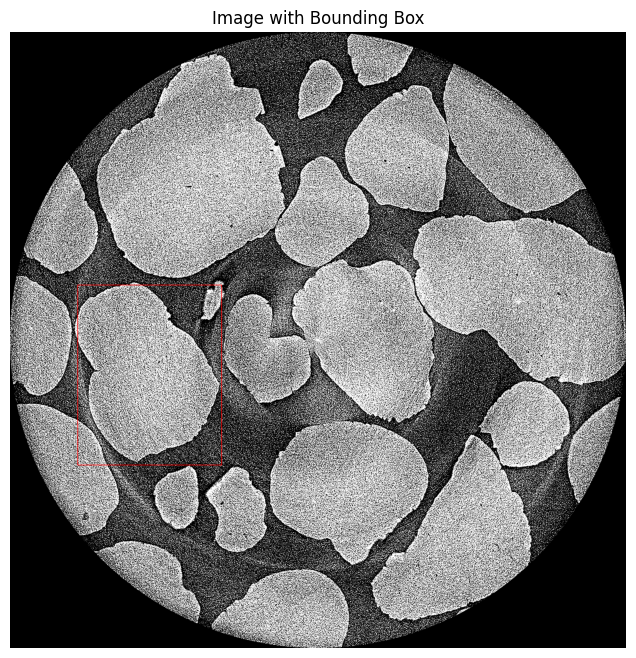

In [31]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Draw box on image for visualization
img_with_box = image.copy()
draw = ImageDraw.Draw(img_with_box)
box = [280, 1050, 880, 1800]
draw.rectangle(box, outline="red", width=3)

# Display inline in notebook
plt.figure(figsize=(10, 8))
plt.imshow(img_with_box)
plt.axis('off')  # Hide axes
plt.title('Image with Bounding Box')
plt.show()

In [ ]:
import numpy as np
import matplotlib
# Box in xyxy format: [x1, y1, x2, y2] in pixel coordinates
# Example: laptop region
box_xyxy = [280, 1050, 880, 1800]
input_boxes = [[box_xyxy]]  # [batch, num_boxes, 4]
input_boxes_labels = [[1]]  # 1 = positive box

inputs = processor(
    images=image,
    input_boxes=input_boxes,
    input_boxes_labels=input_boxes_labels,
    return_tensors="pt"
).to(device)

with torch.no_grad():
    outputs = model(**inputs)

# Post-process results
results = processor.post_process_instance_segmentation(
    outputs,
    threshold=0.5,
    mask_threshold=0.5,
    target_sizes=inputs.get("original_sizes").tolist()
)[0]

def overlay_masks(image, masks):
    image = image.convert("RGBA")
    masks = 255 * masks.cpu().numpy().astype(np.uint8)
    
    n_masks = masks.shape[0]
    cmap = matplotlib.colormaps.get_cmap("rainbow").resampled(n_masks)
    colors = [
        tuple(int(c * 255) for c in cmap(i)[:3])
        for i in range(n_masks)
    ]

    for mask, color in zip(masks, colors):
        mask = Image.fromarray(mask)
        overlay = Image.new("RGBA", image.size, color + (0,))
        alpha = mask.point(lambda v: int(v * 0.5))
        overlay.putalpha(alpha)
        image = Image.alpha_composite(image, overlay)
    return image

overlay_masks(image, results["masks"])



Using device: cpu


Loading weights: 100%|██████████| 1468/1468 [00:01<00:00, 1338.71it/s, Materializing param=vision_encoder.neck.fpn_layers.3.proj2.weight]                       


The OrderedVocab you are attempting to save contains holes for indices [1], your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains holes for indices [1], your vocabulary could be corrupted !
Segmenting sand...
Segmenting air...
Segmenting background...

=== Results ===
Sand: 22
Air: 7
Background: 1


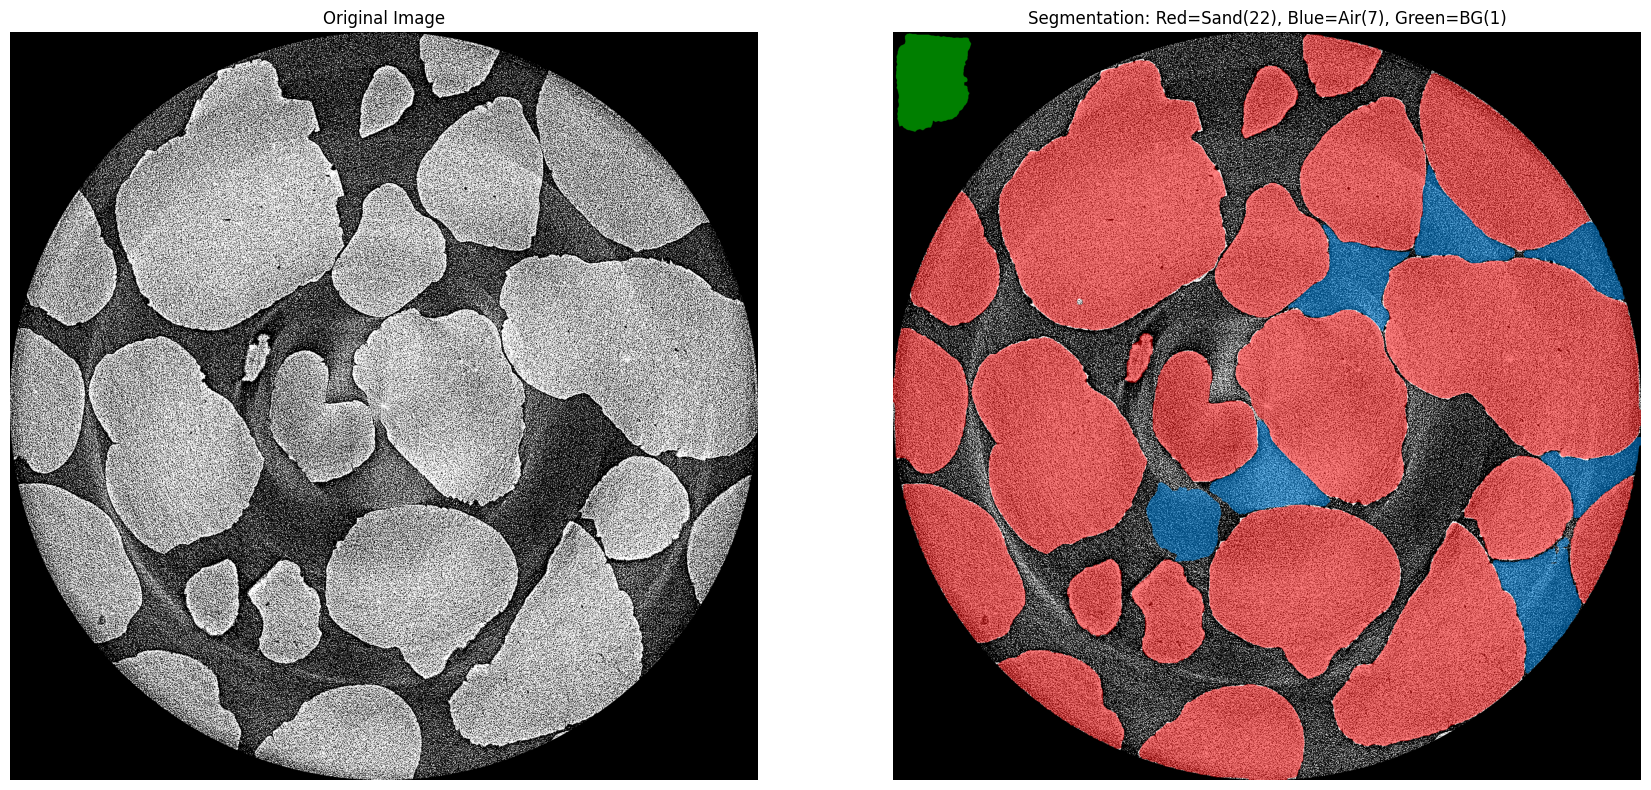

In [5]:
from transformers import Sam3Processor, Sam3Model
import torch
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = Sam3Model.from_pretrained("facebook/sam3").to(device)
processor = Sam3Processor.from_pretrained("facebook/sam3")

# Load image
image = Image.open("./20240425_112716_nist-sand-30-100_27keV_z8mm_n2625_00000.png").convert("RGB")

# Define boxes
background_box = [0, 0, 300, 300]
air_box = [880, 1550, 1100, 1800]
sand_box = [280, 1050, 880, 1800]

# ===== Segment SAND (no negative boxes) =====
print("Segmenting sand...")
inputs = processor(
    images=image,
    input_boxes=[[sand_box]],  # Only positive box
    input_boxes_labels=[[1]],   # Only positive label
    return_tensors="pt"
).to(device)

with torch.no_grad():
    outputs = model(**inputs)

sand_results = processor.post_process_instance_segmentation(
    outputs,
    threshold=0.5,
    mask_threshold=0.5,
    target_sizes=inputs.get("original_sizes").tolist()
)[0]

# ===== Segment AIR (no negative boxes) =====
print("Segmenting air...")
inputs = processor(
    images=image,
    input_boxes=[[air_box]],   # Only positive box
    input_boxes_labels=[[1]],   # Only positive label
    return_tensors="pt"
).to(device)

with torch.no_grad():
    outputs = model(**inputs)

air_results = processor.post_process_instance_segmentation(
    outputs,
    threshold=0.5,
    mask_threshold=0.5,
    target_sizes=inputs.get("original_sizes").tolist()
)[0]

# ===== Segment BACKGROUND (no negative boxes) =====
print("Segmenting background...")
inputs = processor(
    images=image,
    input_boxes=[[background_box]],  # Only positive box
    input_boxes_labels=[[1]],         # Only positive label
    return_tensors="pt"
).to(device)

with torch.no_grad():
    outputs = model(**inputs)

background_results = processor.post_process_instance_segmentation(
    outputs,
    threshold=0.5,
    mask_threshold=0.5,
    target_sizes=inputs.get("original_sizes").tolist()
)[0]

print(f"\n=== Results ===")
print(f"Sand: {len(sand_results['masks'])}")
print(f"Air: {len(air_results['masks'])}")
print(f"Background: {len(background_results['masks'])}")

# Define overlay_masks function
def overlay_masks(image, masks, colors=None):
    """Overlay masks on image with different colors"""
    image = image.convert("RGBA")
    masks = 255 * masks.cpu().numpy().astype(np.uint8)
    
    n_masks = masks.shape[0]
    
    if colors is None:
        cmap = matplotlib.colormaps.get_cmap("rainbow").resampled(n_masks)
        colors = [
            tuple(int(c * 255) for c in cmap(i)[:3])
            for i in range(n_masks)
        ]
    
    for mask, color in zip(masks, colors):
        mask_img = Image.fromarray(mask)
        overlay = Image.new("RGBA", image.size, color + (0,))
        alpha = mask_img.point(lambda v: int(v * 0.5))
        overlay.putalpha(alpha)
        image = Image.alpha_composite(image, overlay)
    
    return image

# Combine all masks
all_masks = []
all_colors = []

if len(sand_results['masks']) > 0:
    all_masks.extend(sand_results['masks'])
    all_colors.extend([(255, 0, 0)] * len(sand_results['masks']))

if len(air_results['masks']) > 0:
    all_masks.extend(air_results['masks'])
    all_colors.extend([(0, 150, 255)] * len(air_results['masks']))

if len(background_results['masks']) > 0:
    all_masks.extend(background_results['masks'])
    all_colors.extend([(0, 255, 0)] * len(background_results['masks']))

# Create visualization
if all_masks:
    combined_masks = torch.stack(all_masks)
    combined_overlay = overlay_masks(image, combined_masks, all_colors)
    
    # Display
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(combined_overlay)
    axes[1].set_title(f'Segmentation: Red=Sand({len(sand_results["masks"])}), Blue=Air({len(air_results["masks"])}), Green=BG({len(background_results["masks"])})')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No masks found!")

Using device: cpu


Loading weights: 100%|██████████| 1468/1468 [00:01<00:00, 1381.44it/s, Materializing param=vision_encoder.neck.fpn_layers.3.proj2.weight]                       


The OrderedVocab you are attempting to save contains holes for indices [1], your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains holes for indices [1], your vocabulary could be corrupted !
Segmenting sand with multiple examples...
Segmenting air with multiple examples...
Segmenting background with multiple examples...

=== Results ===
Sand: 22 (from 1 examples)
Air: 2 (from 2 examples)
Background: 2 (from 2 examples)


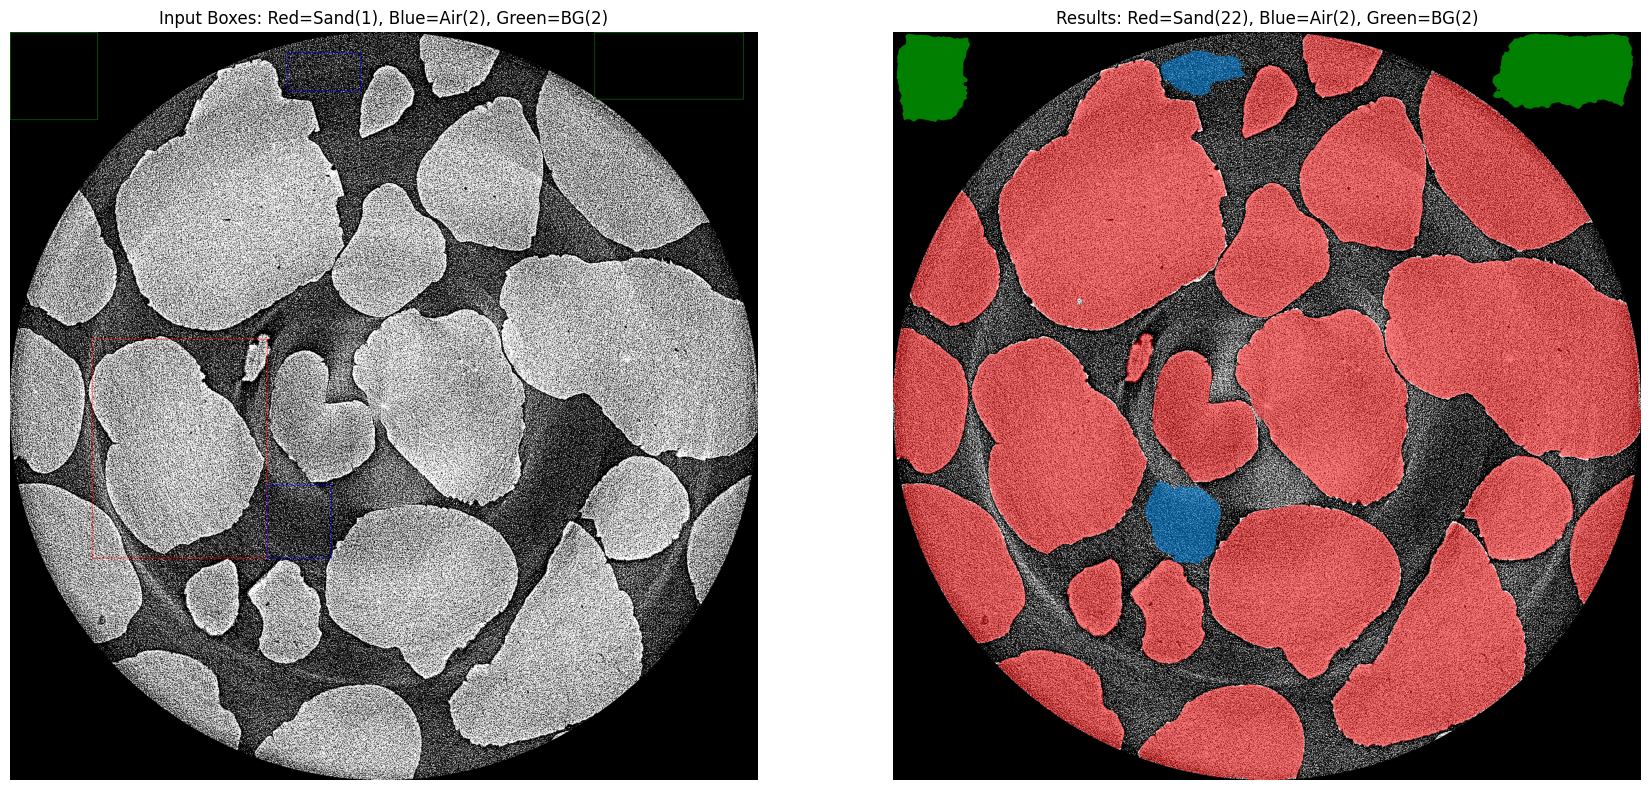

In [23]:
from transformers import Sam3Processor, Sam3Model
import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = Sam3Model.from_pretrained("facebook/sam3").to(device)
processor = Sam3Processor.from_pretrained("facebook/sam3")

# Load image
image = Image.open("./20240425_112716_nist-sand-30-100_27keV_z8mm_n2625_00000.png").convert("RGB")

# ===== Define MULTIPLE boxes for each type =====

# Multiple SAND particle examples
sand_boxes = [
    [280, 1050, 880, 1800],   # Example 1: large sand particle
]

# Multiple AIR region examples
air_boxes = [
    [880, 1550, 1100, 1800],   # Example 1: air region
    [950, 70, 1200, 200],        # Example 2: another air region
]

# Multiple BACKGROUND examples
background_boxes = [
    [0, 0, 300, 300],           # Example 1: background corner
    [2000, 0, 2510, 230],        # Example 2: another background region
]

# ===== Segment SAND with multiple boxes =====
print("Segmenting sand with multiple examples...")
inputs = processor(
    images=image,
    input_boxes=[sand_boxes],  # List of multiple boxes
    input_boxes_labels=[[1] * len(sand_boxes)],  # All positive
    return_tensors="pt"
).to(device)

with torch.no_grad():
    outputs = model(**inputs)

sand_results = processor.post_process_instance_segmentation(
    outputs,
    threshold=0.5,
    mask_threshold=0.5,
    target_sizes=inputs.get("original_sizes").tolist()
)[0]

# ===== Segment AIR with multiple boxes =====
print("Segmenting air with multiple examples...")
inputs = processor(
    images=image,
    input_boxes=[air_boxes],  # List of multiple boxes
    input_boxes_labels=[[1] * len(air_boxes)],  # All positive
    return_tensors="pt"
).to(device)

with torch.no_grad():
    outputs = model(**inputs)

air_results = processor.post_process_instance_segmentation(
    outputs,
    threshold=0.5,
    mask_threshold=0.5,
    target_sizes=inputs.get("original_sizes").tolist()
)[0]

# ===== Segment BACKGROUND with multiple boxes =====
print("Segmenting background with multiple examples...")
inputs = processor(
    images=image,
    input_boxes=[background_boxes],  # List of multiple boxes
    input_boxes_labels=[[1] * len(background_boxes)],  # All positive
    return_tensors="pt"
).to(device)

with torch.no_grad():
    outputs = model(**inputs)

background_results = processor.post_process_instance_segmentation(
    outputs,
    threshold=0.5,
    mask_threshold=0.5,
    target_sizes=inputs.get("original_sizes").tolist()
)[0]

print(f"\n=== Results ===")
print(f"Sand: {len(sand_results['masks'])} (from {len(sand_boxes)} examples)")
print(f"Air: {len(air_results['masks'])} (from {len(air_boxes)} examples)")
print(f"Background: {len(background_results['masks'])} (from {len(background_boxes)} examples)")

# Visualization
def overlay_masks(image, masks, colors=None):
    """Overlay masks on image with different colors"""
    image = image.convert("RGBA")
    masks = 255 * masks.cpu().numpy().astype(np.uint8)
    
    n_masks = masks.shape[0]
    
    if colors is None:
        cmap = matplotlib.colormaps.get_cmap("rainbow").resampled(n_masks)
        colors = [
            tuple(int(c * 255) for c in cmap(i)[:3])
            for i in range(n_masks)
        ]
    
    for mask, color in zip(masks, colors):
        mask_img = Image.fromarray(mask)
        overlay = Image.new("RGBA", image.size, color + (0,))
        alpha = mask_img.point(lambda v: int(v * 0.5))
        overlay.putalpha(alpha)
        image = Image.alpha_composite(image, overlay)
    
    return image

# Combine all masks
all_masks = []
all_colors = []

if len(sand_results['masks']) > 0:
    all_masks.extend(sand_results['masks'])
    all_colors.extend([(255, 0, 0)] * len(sand_results['masks']))

if len(air_results['masks']) > 0:
    all_masks.extend(air_results['masks'])
    all_colors.extend([(0, 150, 255)] * len(air_results['masks']))

if len(background_results['masks']) > 0:
    all_masks.extend(background_results['masks'])
    all_colors.extend([(0, 255, 0)] * len(background_results['masks']))

# Create visualization
if all_masks:
    combined_masks = torch.stack(all_masks)
    combined_overlay = overlay_masks(image, combined_masks, all_colors)
    
    # Display with input boxes
    from PIL import ImageDraw
    img_with_boxes = image.copy()
    draw = ImageDraw.Draw(img_with_boxes)
    
    for box in sand_boxes:
        draw.rectangle(box, outline="red", width=2)
    for box in air_boxes:
        draw.rectangle(box, outline="blue", width=2)
    for box in background_boxes:
        draw.rectangle(box, outline="green", width=2)
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    axes[0].imshow(img_with_boxes)
    axes[0].set_title(f'Input Boxes: Red=Sand({len(sand_boxes)}), Blue=Air({len(air_boxes)}), Green=BG({len(background_boxes)})')
    axes[0].axis('off')
    
    axes[1].imshow(combined_overlay)
    axes[1].set_title(f'Results: Red=Sand({len(sand_results["masks"])}), Blue=Air({len(air_results["masks"])}), Green=BG({len(background_results["masks"])})')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()